# Svenskt Kvinnobiografiskt lexikon - SKBL part 3
    version part 3 - 2.7
 
 This [notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  
  
  * SKBL see https://skbl.se/en  
    * example structured data from SKBL [GretaGarbo JSON](https://skbl.se/en/article/GretaGarbo.json)
    * video 
      * in [Swedish what we do today](https://youtu.be/LBx7XowzrJ0)
      * the vision with [Wikidata <-> SKBL](https://www.youtube.com/watch?v=HIHO-szkD1A)
    * [presentation](https://docs.google.com/presentation/d/1EvQHdzPsIA4hr2WuNXnbpsLHec2GS89b_pHvilO6xhQ/edit?usp=sharing) about start using Linked data at SKBL and have same as Wikidata 
    
  
### Purpose
  * gets statistics about SKBL and compare number of articles produced with what The Swedish National archives [SBL biographies](https://sok.riksarkivet.se/sbl/Start.aspx?lang=en) has produced since 1918
  * check if SKBL has new articles created not added to [Wikidata](https://www.youtube.com/watch?v=m_9_23jXPoE)

#### Other sources we sync
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb)
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)  
* [Svenska Akademin](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademin.ipynb)  


### Links
* [video](https://www.youtube.com/watch?v=6jxH8MBIhvg) in Swedish about how SKBL deliver and work with Wikidata
  * Example how project Women in Red at en:Wikipedia automatic [creates dynamic lists of "missing" articles](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW) that shows what in SKBL has an english article about a women but not have an english article in en:Wikipedia
    * see [version history](https://en.wikipedia.org/w/index.php?title=Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW&action=history) of list created
    * see en:Wikipedia articles [with a link to SKBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) > 680 articles using the [SKBL template](https://en.wikipedia.org/wiki/Template:SKBL)

Below we also use Wikidata to compare number of female articles produced
* [SKBL started 2018](https://skbl.se/en/about-skbl)
  * use a data driven approach with structured data
  * has swedish/english articles see [https://pageviews.toolforge.org/massviews/?platform=all-access&agent=user&source=category&range=this-year&subjectpage=0&subcategories=0&sort=views&direction=1&view=list&target=https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963 statistics en:Wikipedia]
     * page views in different languages for [Ingrid Bergman](https://pageviews.toolforge.org/langviews/?project=en.wikipedia.org&platform=all-access&agent=user&range=latest-20&sort=views&direction=1&view=list&page=Ingrid%20Bergman)
* [SBL started 1917](https://sok.riksarkivet.se/sbl/Start.aspx?lang=en)
  * publish on paper and then scan the paper and creates a webpage with no machinereadable structured data  

**See also**
* video [Introduction to Wikidata](https://www.youtube.com/watch?v=m_9_23jXPoE)

In [2]:
import ipyplot
listOfImageNames = ['SBLmalefemale.png','SKBLSBLfemale.png','SKBLPiepublished.png',
                   'SKBLBarpublished.png','en_Wikipedia_SKBL_views-20200101-20200919.png',
                    'SBL_published_articles_1918-2018.png','SBL_published_articles_women_1918-2018.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

* Map with [SKBL ladies](https://w.wiki/cyv) born,died,buried...
* [Other external properties](https://w.wiki/czi) in WD on records that has the SKBL property 

In [3]:
import IPython 
#iframe = '<iframe width="900" height="800" frameborder="0" scrolling="no" src="https://w.wiki/cyv"></iframe>'
#IPython.display.IFrame(src="https://w.wiki/cyv",width=900,height=800)

# Wikidata - WDSKBLtot

In [4]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2020-10-09 20:41:29.760226


In [5]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

querySKBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?skblid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P4963 ?skblid
} order by ?skbl"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSKBLtot = get_sparql_dataframe(endpoint_url, querySKBL)
WDSKBLtot["Source"] = "SKBL" 


In [6]:
WDSKBLtot.sort_index(inplace=True)  

In [7]:
WDSKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555 entries, 0 to 1554
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  1555 non-null   object
 1   skblid      1555 non-null   object
 2   Source      1555 non-null   object
dtypes: object(3)
memory usage: 36.6+ KB


## Get SKBL records - SKBLtot

In [8]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None)
pd.set_option('display.max_rows', None)

  
#Ny bättre URL    
url = "https://ws.spraakbanken.gu.se/ws/karp/v5/query?mode=skbl&q=extended%7C%7Cand%7Cskblstatus%7Cequals%7Cok&size=10000"
r = http.request('GET', url) 
data = json.loads(r.data.decode('utf-8')) 
#print(type(data))
#print(r.info())  

listSKBL = []
i = 0 
for row in (data["hits"]["hits"]):
    #print (row["_source"]["url"])
    new_item = dict()
    new_item['skblid'] = row["_source"]["url"]
   
    try:
        publishedDate = row["_source"]['publication_date']        
    except:
        publishedDate =""
    new_item['publishedDate'] = publishedDate
    try:
        article_author_firstname = row["_source"]["article_author"][0]['firstname']
    except:
        article_author_firstname =""
    new_item['article_author_firstname'] = article_author_firstname
    try:
        article_author_lastname = row["_source"]["article_author"][0]['lastname']
    except:
        article_author_lastname =""
    new_item['article_author_lastname'] = article_author_lastname
    try:
        subtitle_sv = row["_source"]['subtitle']
    except:
        subtitle_sv =""
    new_item['subtitle_sv'] = subtitle_sv
    try:
        name_lastname = row["_source"]['name']['lastname']
    except:
        name_lastname = ""
    new_item['name_lastname'] = name_lastname
    try:
        name_firstname = row["_source"]['name']['firstname']
    except:
        name_firstname = ""
    new_item['name_firstname'] = name_firstname
    listSKBL.append(new_item)
    i = i + 1 
    #print (i)
print (len(listSKBL) ," antal poster")


1555  antal poster


In [9]:
SKBLtot = pd.DataFrame(listSKBL,
                  columns=['skblid','publishedDate','article_author_firstname','article_author_lastname',
                          'subtitle_sv','name_lastname','name_firstname'])

In [10]:
SKBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555 entries, 0 to 1554
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   skblid                    1555 non-null   object
 1   publishedDate             1555 non-null   object
 2   article_author_firstname  1555 non-null   object
 3   article_author_lastname   1555 non-null   object
 4   subtitle_sv               1555 non-null   object
 5   name_lastname             1555 non-null   object
 6   name_firstname            1555 non-null   object
dtypes: object(7)
memory usage: 85.2+ KB


In [11]:
SKBLtot["publishedDate"] = SKBLtot["publishedDate"].astype("datetime64")
SKBLtot["Source"] = "SKBL"

In [12]:
%matplotlib inline    
import matplotlib.pyplot as plt   


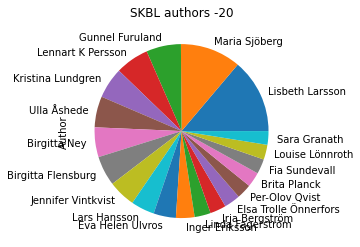

In [13]:
plotPublishedAuthor = SKBLtot  
  
plotPublishedAuthor["Author"] = plotPublishedAuthor["article_author_firstname"] + " " + plotPublishedAuthor["article_author_lastname"]   
plotAuthor = plotPublishedAuthor["Author"].value_counts()[:20]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors -20")
plt.show()

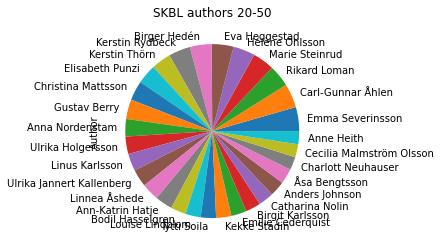

In [14]:
plotAuthor = plotPublishedAuthor["Author"].value_counts()[20:50]
plotAuthor.plot( kind = 'pie') 
plt.title("SKBL authors 20-50")
plt.show()

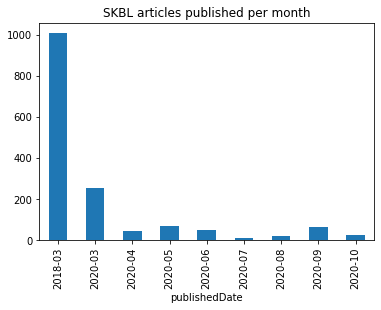

In [15]:
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby(df['last_payout'].dt.to_period('M')).sum().plot(kind='bar')
#plotPublishedperMonth = dfSKBLAuthorcsv['publishedDate'].groupby([dfSKBLAuthorcsv.publishedDate.year,dfSKBLAuthorcsv.publishedDate.month].agg('count'))
plotPublishedperMonth = SKBLtot['publishedDate'].groupby(SKBLtot.publishedDate.dt.to_period("M")).agg('count')
plotPublishedperMonth.plot( kind = 'bar') 
plt.title("SKBL articles published per month")
plt.savefig('SKBLBarpublished.png')  
plt.show()

In [16]:
plotPublishedperMonth

publishedDate
2018-03    1008
2020-03     254
2020-04      47
2020-05      71
2020-06      51
2020-07      11
2020-08      22
2020-09      67
2020-10      24
Freq: M, Name: publishedDate, dtype: int64

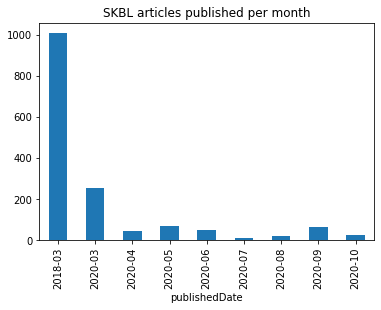

In [17]:
plotPublishedperMonth = SKBLtot['publishedDate'].groupby(SKBLtot.publishedDate.dt.to_period("M")).agg('count')
plotPublishedperMonth.plot( kind = 'bar') 
plt.title("SKBL articles published per month")
plt.savefig('SKBLBarpublished.png')  
plt.show()

In [18]:
plotPublishedperMonth

publishedDate
2018-03    1008
2020-03     254
2020-04      47
2020-05      71
2020-06      51
2020-07      11
2020-08      22
2020-09      67
2020-10      24
Freq: M, Name: publishedDate, dtype: int64

In [19]:
plotPublishedperMonth.sum()

1555

In [20]:
print("Nr articles left to the goal 2000 = ",2000- plotPublishedperMonth.sum())

Nr articles left to the goal 2000 =  445


In [21]:
#Nr working days to 2021 when we should have 2000 profiles
print("Nr working days left =",pd.bdate_range(datetime.today(),'2021-01-01').value_counts().sum(),
      "==> Articles per day needed = ",(2000- plotPublishedperMonth.sum())/pd.bdate_range(datetime.today(),'2021-01-01').value_counts().sum())

Nr working days left = 61 ==> Articles per day needed =  7.295081967213115


In [22]:
#plotPublishedAccumalted

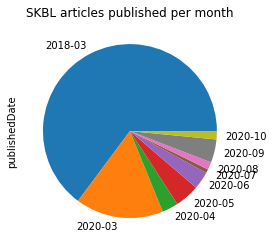

In [23]:
plotPublishedperMonth.plot( kind = 'pie') 
plt.title("SKBL articles published per month") 
plt.savefig('SKBLPiepublished.png')
plt.show()

In [24]:
pd.set_option('display.max_rows', None) 
# Sort latest first 
#dfSKBLAuthorcsv.sort_values(by=['publishedDate'], ascending=[False])

In [25]:
from IPython.display import display, HTML  
plotPublishedAuthor['Link'] = plotPublishedAuthor['skblid'].apply(lambda x: "https://skbl.se/sv/artikel/{0}".format(x))  
plotPublishedAuthor.style.set_properties(subset=['publishedDate'], **{'width': '200px'}) 

# Merge plotPublishedAuthor WDSKBLtot  
mergeSKBLWD = pd.merge(WDSKBLtot, plotPublishedAuthor,how='outer', on='skblid',indicator=True)   
mergeSKBLWD.rename(columns={"_merge": "WD_SKBL"},inplace = True)
mergeSKBLWD['WD_SKBL'] = mergeSKBLWD['WD_SKBL'].str.replace('left_only','WD_only').str.replace('right_only','SKBL_only')
mergeSKBLWD["WD_SKBL"].value_counts()  


both    1555
Name: WD_SKBL, dtype: int64

### Latest articles in SKBL

In [26]:
# de sista 10 publiserade biografier 
mergeSKBLWD = mergeSKBLWD.sort_values(by=['publishedDate'], ascending=[False])
mergeSKBLWD = mergeSKBLWD.reset_index(drop=True)  

mergeSKBLWD[:5]

,WikidataID,skblid,Source_x,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,name_lastname,name_firstname,Source_y,Author,Link,WD_SKBL
0,Q24005875,ElsaBritaStjernberg,SKBL,2020-10-09,Gunilla,Linde Bjur,"Arkitekt, pionjär",Stjernberg,Elsa Brita (/Elsa-Brita/),SKBL,Gunilla Linde Bjur,https://skbl.se/sv/artikel/ElsaBritaStjernberg,both
1,Q100234952,AgdaHaglund,SKBL,2020-10-09,Catharina,Nolin,"Trädgårdsarkitekt, skribent",Haglund,/Agda/ Viktoria,SKBL,Catharina Nolin,https://skbl.se/sv/artikel/AgdaHaglund,both
2,Q44614992,BarbroGunillaMyrberg,SKBL,2020-10-09,Gunilla,Bolinder,"Vetenskapsjournalist, författare, pionjär",Myrberg,Barbro /Gunilla/,SKBL,Gunilla Bolinder,https://skbl.se/sv/artikel/BarbroGunillaMyrberg,both
3,Q75246072,ElisabetAnnaavBraunschweigLuneburg,SKBL,2020-10-09,Johanna,Thorelli,"Grevinna, godsägare",,/Elisabet/ Anna av Braunschweig-Lüneburg,SKBL,Johanna Thorelli,https://skbl.se/sv/artikel/ElisabetAnnaavBraun...,both
4,Q76148175,BibbiOlsson,SKBL,2020-10-09,Gunilla,Linde Bjur,Arkitekt,Olsson,Birgit (/Bibbi/),SKBL,Gunilla Linde Bjur,https://skbl.se/sv/artikel/BibbiOlsson,both


## Compare SBL
SBL started in 1918 and is published by the [National Archives](https://sok.riksarkivet.se/sbl/Start.aspx?lang=en) in Sweden. They have
* No API
* focus on publish on paper
* dont have structured data
* no understanding of [Linked data](https://vimeo.com/36752317)
* we have before manually been adding links but also tried doing webscrabing to populate [Wikidata P3217](https://www.wikidata.org/wiki/Property_talk:P3217) now I guess we wait on SBL for delivering data as data see question asked [236883](https://phabricator.wikimedia.org/T236883) Oct 30 2019, 11:03 AM - no official answer so far and The Swedish National Archives has no helpdesk system were you get an unique helpdesk number ([some action was promised aug 2018 by Rolf Källman](https://twitter.com/salgo60/status/1030269242296414208?s=20) nothing heard)

### Wikidata <-> SBL updated
We did a NEW try getting structure from webscrabed data see [Jupyter Notebook](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) as SBL is non structured data we will get errors and also problem understand what is an article about a family and what is about a person.... 

In [27]:
# SPARQL 
querySBL = """SELECT distinct (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?sblid  ?skblid ?genderLabel  WHERE {
?item wdt:P31 wd:Q5.
OPTIONAL {?item wdt:P21 ?gender}
?item wdt:P3217 ?sblid
OPTIONAL {?item wdt:P4963 ?skblid}
SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
} order by ?sblid """


WDSBLtot = get_sparql_dataframe(endpoint_url, querySBL)
WDSBLtot["Source"] = "SBL" 
#WDSBLtot.info()

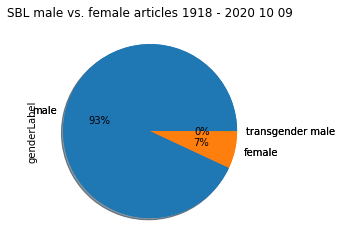

In [28]:
plotSBLgender = WDSBLtot["genderLabel"].value_counts()
plotSBLgender.plot( kind = 'pie') 
plt.title("Riksarkivet SBL male/female")
plot = plotSBLgender.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("SBL male vs. female articles 1918 - " + start_time.strftime('%Y %m %d'))
plt.savefig('SBLmalefemale.png')
plt.show()

In [29]:
plotSBLgender

male                7071
female               527
transgender male       1
Name: genderLabel, dtype: int64

In [30]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7599 entries, 0 to 7598
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   WikidataID   7599 non-null   object
 1   sblid        7599 non-null   object
 2   skblid       336 non-null    object
 3   genderLabel  7599 non-null   object
 4   Source       7599 non-null   object
dtypes: object(5)
memory usage: 297.0+ KB


In [31]:
WDSBLtot[WDSBLtot.duplicated(subset=['WikidataID'])]

,WikidataID,sblid,skblid,genderLabel,Source


In [32]:
plotSBLgender

male                7071
female               527
transgender male       1
Name: genderLabel, dtype: int64

In [33]:
plotSBLfemale = WDSBLtot[WDSBLtot["genderLabel"] == "female"] 
#plotSBLfemale["birth"] = plotSBLfemale["birth"].astype("datetime64")
#plotSBLfemale.info() 

In [34]:
end = datetime.now()
print("Ended: ", end)

Ended:  2020-10-09 20:41:48.624391


In [35]:
dfmerge = pd.merge(plotSBLfemale, mergeSKBLWD,how='outer', on='WikidataID',indicator=True)

In [36]:
#dfmerge.info()

In [37]:
dfmerge["_merge"].value_counts()

right_only    1220
both           335
left_only      192
Name: _merge, dtype: int64

In [38]:
# both is number in bioth SBL and SKBL   
# right_only is SBL
# left_only is SKBL

In [39]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','SBL_only').str.replace('right_only','SKBL_only')
dfmerge.rename(columns={"_merge": "SBL_SKBL"},inplace = True)

#dfmerge[0:10]  


In [40]:
mergeCheck = dfmerge[['WikidataID', 'sblid','skblid_x','publishedDate','SBL_SKBL']] 
mergeCheck.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1747 entries, 0 to 1746
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   WikidataID     1747 non-null   object        
 1   sblid          527 non-null    object        
 2   skblid_x       335 non-null    object        
 3   publishedDate  1555 non-null   datetime64[ns]
 4   SBL_SKBL       1747 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 81.9+ KB


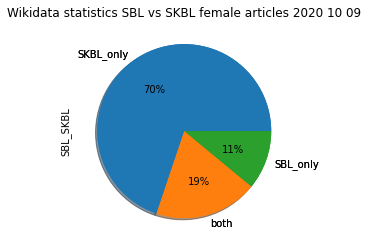

In [41]:
mergeCheckNumber = mergeCheck["SBL_SKBL"].value_counts()
mergeCheckNumber.plot( kind = 'pie')  
plot = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0)
plt.title("Wikidata statistics SBL vs SKBL female articles " + start_time.strftime('%Y %m %d'))
plt.savefig('SKBLSBLfemale.png')
plt.show()


In [42]:
mergeCheckNumber

SKBL_only    1220
both          335
SBL_only      192
Name: SBL_SKBL, dtype: int64

In [43]:
#Profiles missing in SKBL that SBL has written = left_only 
WDSBLonly = mergeCheck[mergeCheck["SBL_SKBL"] == "SBL_only"].copy() 

In [44]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 523
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   WikidataID     192 non-null    object        
 1   sblid          192 non-null    object        
 2   skblid_x       0 non-null      object        
 3   publishedDate  0 non-null      datetime64[ns]
 4   SBL_SKBL       192 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 9.0+ KB


In [45]:
WDSBLonly["sbl"] = "https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=" + WDSBLonly["sblid"] 
pd.set_option('column_space', 20)
pd.set_option('max_colwidth', 300)

WDSBLonly[["WikidataID","sblid","sbl"]][:10]

,WikidataID,sblid,sbl
0,Q1794132,10025,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10025
3,Q4942488,10132,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10132
5,Q16595614,10248,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10248
7,Q16595619,10332,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10332
9,Q42399094,10396,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10396
11,Q4767223,10404,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10404
12,Q4962366,10417,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10417
13,Q11857592,10445,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10445
22,Q38373456,10673,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10673
23,Q4963073,10728,https://sok.riksarkivet.se/Sbl/Presentation.aspx?id=10728


### Same query in Wikidata 
* Find all women [in SBL but not in SKBL](https://w.wiki/bFw) < 196 women
* Find all women [in SBL but not in SKBL and have an en:Wikipedia article](https://w.wiki/bFy) < 128 
### Wikipedia articles linking SKBL 
* sv:Wikipedia [usage template Authority](https://sv.wikipedia.org/wiki/Kategori:Wikipediaartiklar_med_identifierare_fr%C3%A5n_SKBL) > 1410
  * **[Issue 23](https://github.com/spraakbanken/skbl-portal/issues/23)** SKBL has no date when the article is  translated maybe bad "workaround" is check tag **text_eng** that is missing in a non translated article as [JosephineGabrielleMarcelleMeunierSainteClaire.json](https://skbl.se/sv/artikel/JosephineGabrielleMarcelleMeunierSainteClaire.json) compare translated [article](https://skbl.se/sv/artikel/JennyLind.json) and then check that all articles with **text_eng** has [template SBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963)
* en:Wikipedia [usage template SKBL](https://en.wikipedia.org/wiki/Category:SKBL_template_using_Wikidata_property_P4963) > 686 articles

### Lists related to SKBL
* en:Wikipedia [Women in Red SKBL](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Women_in_Red/Missing_articles_by_dictionary/BDSW) list with articles "missing" in en:Wikipedia but in SKBL
* sv:Wikipedia [articles missing](https://w.wiki/Zun) but in SKBL


In [46]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 523
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   WikidataID     192 non-null    object        
 1   sblid          192 non-null    object        
 2   skblid_x       0 non-null      object        
 3   publishedDate  0 non-null      datetime64[ns]
 4   SBL_SKBL       192 non-null    object        
 5   sbl            192 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 10.5+ KB


In [47]:
dfmerge["SBL_SKBL"].value_counts()

SKBL_only    1220
both          335
SBL_only      192
Name: SBL_SKBL, dtype: int64

In [48]:
mergeSKBLWD["WD_SKBL"].value_counts() 

both    1555
Name: WD_SKBL, dtype: int64

In [49]:
#List new SKBL articles not in Wikidata
mergeSKBLWD[mergeSKBLWD["WD_SKBL"] == "SKBL_only"] 

,WikidataID,skblid,Source_x,publishedDate,article_author_firstname,article_author_lastname,subtitle_sv,name_lastname,name_firstname,Source_y,Author,Link,WD_SKBL


In [50]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Ended:  2020-10-09 20:41:48.888424
Time elapsed (hh:mm:ss.ms) 0:00:19.128571


### more links 
  * this [Jupyter Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb) [tinyurl.com/SKBLSBL](https://tinyurl.com/SKBLSBL)
    * [part 1](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon.ipynb) check Wikidata and SKBL - obsolete is done in this Notebook 
    * [part 2](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%202.ipynb) more queries etc.
    * [part 4](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%204.ipynb) test extract archives
    * [part 5](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%205.ipynb) check Uppsala University Alvin
    * [SKBL issue board](https://github.com/spraakbanken/skbl-portal/issues) on GitHub
      * open [SKBL 23](https://github.com/spraakbanken/skbl-portal/issues/23) field when translated
      * open [SKBL 24](https://github.com/spraakbanken/skbl-portal/issues/24) fail when send a chenge request in SKBL
